# Automated ML

TODO: Import Dependencies. In the cell below, import all the dependencies that you will need to complete the project.

In [21]:
from azureml.core import Workspace, Experiment

from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

from azureml.data.dataset_factory import TabularDatasetFactory
from azureml.core import Dataset

#import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

from azureml.train.automl import AutoMLConfig

from azureml.widgets import RunDetails

from azureml.core import Model

import joblib

from azureml.core.webservice import AciWebservice, Webservice

## Dataset

### Overview
TODO: In this markdown cell, give an overview of the dataset you are using. Also mention the task you will be performing.


TODO: Get data. In the cell below, write code to access the data you will be using in this project. Remember that the dataset needs to be external.

In [2]:
ws = Workspace.from_config()
exp = Experiment(workspace=ws, name="capstone")

print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep = '\n')

run = exp.start_logging()

Workspace name: quick-starts-ws-137812
Azure region: southcentralus
Subscription id: b968fb36-f06a-4c76-a15f-afab68ae7667
Resource group: aml-quickstarts-137812


In [3]:
cpu_cluster_name = "udacity-project3"

# Verify that cluster does not exist already
try:
    cpu_cluster = ComputeTarget(workspace=ws, name=cpu_cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D2_V2',
                                                           max_nodes=4)
    cpu_cluster = ComputeTarget.create(ws, cpu_cluster_name, compute_config)

cpu_cluster.wait_for_completion(show_output=True)

Found existing cluster, use it.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


In [4]:
train_link = 'https://raw.githubusercontent.com/piprzyb/Azure3/main/train.csv'
test_link = 'https://raw.githubusercontent.com/piprzyb/Azure3/main/test.csv'
data_train = Dataset.Tabular.from_delimited_files(path=train_link)
data_test = Dataset.Tabular.from_delimited_files(path=test_link)

dataset=data_train.to_pandas_dataframe()
test = data_test.to_pandas_dataframe()

dataset = dataset.append(test)

print(dataset.size)
dataset.head()

750


,sepal_length,sepal_width,petal_length,petal_width,iris_class
0,4.6,3.6,1.0,0.2,Iris-setosa
1,5.7,4.4,1.5,0.4,Iris-setosa
2,6.7,3.1,4.4,1.4,Iris-versicolor
3,4.8,3.4,1.6,0.2,Iris-setosa
4,4.4,3.2,1.3,0.2,Iris-setosa


In [5]:
dataset.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


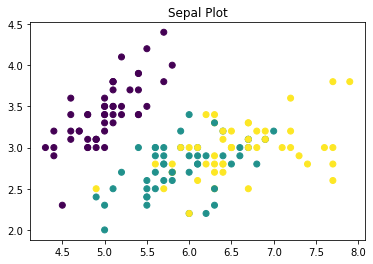

In [6]:
plt.title("Sepal Plot")
plt.scatter('sepal_length', 'sepal_width', c=dataset.iris_class.map({'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2}), data=dataset)
plt.show()

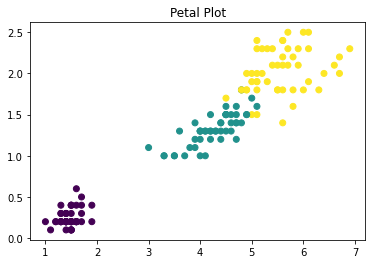

In [7]:
plt.title("Petal Plot")
plt.scatter('petal_length', 'petal_width', c=dataset.iris_class.map({'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2}), data=dataset)
plt.show()

In [8]:
dataset.size

750

## AutoML Configuration

TODO: Explain why you chose the automl settings and cofiguration you used below.

In [11]:
# TODO: Put your automl settings here
automl_settings = {
    'experiment_timeout_minutes': 15,
    'primary_metric' : 'accuracy',
    'n_cross_validations': 5
}

# TODO: Put your automl config here
automl_config = AutoMLConfig(compute_target=cpu_cluster,
                             task = "classification",
                             training_data=data_train,
                             label_column_name='iris_class', 
                             enable_early_stopping= True,
                             experiment_timeout_minutes= 15,
                             primary_metric = 'accuracy',
                             n_cross_validations= 5
                            )

In [13]:
# TODO: Submit your experiment
remote_run = exp.submit(automl_config)
remote_run.wait_for_completion(show_output=True)

Running on remote.

Current status: FeaturesGeneration. Generating features for the dataset.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Class balancing detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and all classes are balanced in your training data.
              Learn more about imbalanced data: https://aka.ms/AutomatedMLImbalancedData

****************************************************************************************************

TYPE:         Missing feature values imputation
STATUS:       PASSED
DESCRIPTION:  No feature missing values were detected in the training data.
              Learn more about missing value imputation: https://aka.ms/AutomatedMLFeaturization

****************************************************************************************************

TYPE:         High cardinality featu

{'runId': 'AutoML_ecb72259-be79-4d1d-bc4e-7fbe2df9fb8f',
 'target': 'udacity-project3',
 'status': 'Completed',
 'startTimeUtc': '2021-02-07T12:46:21.703474Z',
 'endTimeUtc': '2021-02-07T13:16:10.331047Z',
 'properties': {'num_iterations': '1000',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'accuracy',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': '5',
  'target': 'udacity-project3',
  'AMLSettingsJsonString': '{"path":null,"name":"capstone","subscription_id":"b968fb36-f06a-4c76-a15f-afab68ae7667","resource_group":"aml-quickstarts-137812","workspace_name":"quick-starts-ws-137812","region":"southcentralus","compute_target":"udacity-project3","spark_service":null,"azure_service":"remote","many_models":false,"pipeline_fetch_max_batch_size":1,"iterations":1000,"primary_metric":"accuracy","task_type":"classification","data_script":null,"validation_size":0.0,"n_cross_validations":5,"y_min":null,"y_max":null,"num_classe

## Run Details

OPTIONAL: Write about the different models trained and their performance. Why do you think some models did better than others?

TODO: In the cell below, use the `RunDetails` widget to show the different experiments.

In [16]:
RunDetails(remote_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

## Best Model

TODO: In the cell below, get the best model from the automl experiments and display all the properties of the model.



In [17]:
best_run, best_model = remote_run.get_output()
best_run_metrics = best_run.get_metrics()

best_run

Package:azureml-automl-runtime, training version:1.21.0, current version:1.20.0
Package:azureml-core, training version:1.21.0.post1, current version:1.20.0
Package:azureml-dataprep, training version:2.8.2, current version:2.7.3
Package:azureml-dataprep-native, training version:28.0.0, current version:27.0.0
Package:azureml-dataprep-rslex, training version:1.6.0, current version:1.5.0
Package:azureml-dataset-runtime, training version:1.21.0, current version:1.20.0
Package:azureml-defaults, training version:1.21.0, current version:1.20.0
Package:azureml-interpret, training version:1.21.0, current version:1.20.0
Package:azureml-pipeline-core, training version:1.21.0, current version:1.20.0
Package:azureml-telemetry, training version:1.21.0, current version:1.20.0
Package:azureml-train-automl-client, training version:1.21.0, current version:1.20.0
Package:azureml-train-automl-runtime, training version:1.21.0, current version:1.20.0


Experiment,Id,Type,Status,Details Page,Docs Page
capstone,AutoML_ecb72259-be79-4d1d-bc4e-7fbe2df9fb8f_14,azureml.scriptrun,Completed,Link to Azure Machine Learning studio,Link to Documentation


In [18]:
best_model

PipelineWithYTransformations(Pipeline={'memory': None,
                                       'steps': [('datatransformer',
                                                  DataTransformer(enable_dnn=None,
                                                                  enable_feature_sweeping=None,
                                                                  feature_sweeping_config=None,
                                                                  feature_sweeping_timeout=None,
                                                                  featurization_config=None,
                                                                  force_text_dnn=None,
                                                                  is_cross_validation=None,
                                                                  is_onnx_compatible=None,
                                                                  logger=None,
                                                              

In [19]:
print('Best Run Id: ', best_run.id)
print('Accuracy:', best_run_metrics['accuracy'])
print(best_model._final_estimator)

Best Run Id:  AutoML_ecb72259-be79-4d1d-bc4e-7fbe2df9fb8f_14
Accuracy: 0.9833333333333334
PreFittedSoftVotingClassifier(classification_labels=None,
                              estimators=[('9',
                                           Pipeline(memory=None,
                                                    steps=[('sparsenormalizer',
                                                            <azureml.automl.runtime.shared.model_wrappers.SparseNormalizer object at 0x7f9a2e04d588>),
                                                           ('lightgbmclassifier',
                                                            LightGBMClassifier(boosting_type='goss',
                                                                               class_weight=None,
                                                                               colsample_bytree=0.5944444444444444,
                                                                               importance_type='split',
       

In [23]:
#TODO: Save the best model
os.makedirs('./outputs', exist_ok=True)

joblib.dump(best_model, filename='outputs/automl.joblib')

model_name = best_run.properties['model_name']
print(model_name)

AutoMLecb72259b14


## Model Deployment

Remember you have to deploy only one of the two models you trained.. Perform the steps in the rest of this notebook only if you wish to deploy this model.

TODO: In the cell below, register the model, create an inference config and deploy the model as a web service.

In [ ]:
model = best_run.register_model(model_name = 'automl_model', 
                                                model_path='outputs/automl.joblib')

aci_config = AciWebservice.deploy_configuration(cpu_cores=1, memory_gb=2,
                                                enable_app_insights=True, auth_enabled=True)  

service_name = 'service_aml'
service = Model.deploy(ws, service_name, [model], deployment_config=aci_config)
service.wait_for_deployment(show_output = True)
print(service.state)
print(service.scoring_uri)


TODO: In the cell below, send a request to the web service you deployed to test it.

In [ ]:
test_ws = train.tail()
target = test_ws['iris_class']
test_ws = test_ws[:-1]

test_json = json.dumps({'data':test_ws.to_dict(orient='records')})
print(test_json)

results = service.run(teste_json)
print('Model results:', results)
print('Actual results:', y_actual.values)

TODO: In the cell below, print the logs of the web service and delete the service

In [ ]:
print(service.get_logs())

service.delete()